In [16]:
import sys
sys.path.append('../../')

In [17]:
from scripts.utils import data_path, set_mpl, read_hamelin, add_datetime_features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


%matplotlib inline

set_mpl()

matplotlib settings set


In this notebook we will try predicting average energy consumed by households with 2 people occupying the house.

# Data reading and preprocessing 

In [18]:
energy, weather, metadata = read_hamelin()


    Loading Hamelin data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Houses number removed: 6, 17, 24, 25. 
    Houses with PV: ['13', '15', '26', '33'] 
    HOUSEHOLD and HEATPUMP energy consumption are separated. 
    Resolution: 60min 

    May-June 2019 data for home #34 excluded 
    Data before 2018-05-18 excluded (gaps)
    Data with zero difference between consecutive values dropped (malfunction)

    reutrns:
    df_energy: pd.DataFrame with energy consumption data
    df_weather: pd.DataFrame with weather data
    df_metadata: pd.DataFrame with metadata

    


## two-persons households filter

In [19]:

cluster_one = list(metadata.query('inhabitants==2 & area<=200 & area>=100 & index not in [6,17,24,25]').index)


cols_from_cluster_one = [f'P_TOT_{i}' for i in cluster_one]
energy = energy[cols_from_cluster_one]



## Missing data and impuation

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_88340/2024592467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_filled['P_TOT_AVG'] = energy_filled[orig_cols].mean(axis=1)


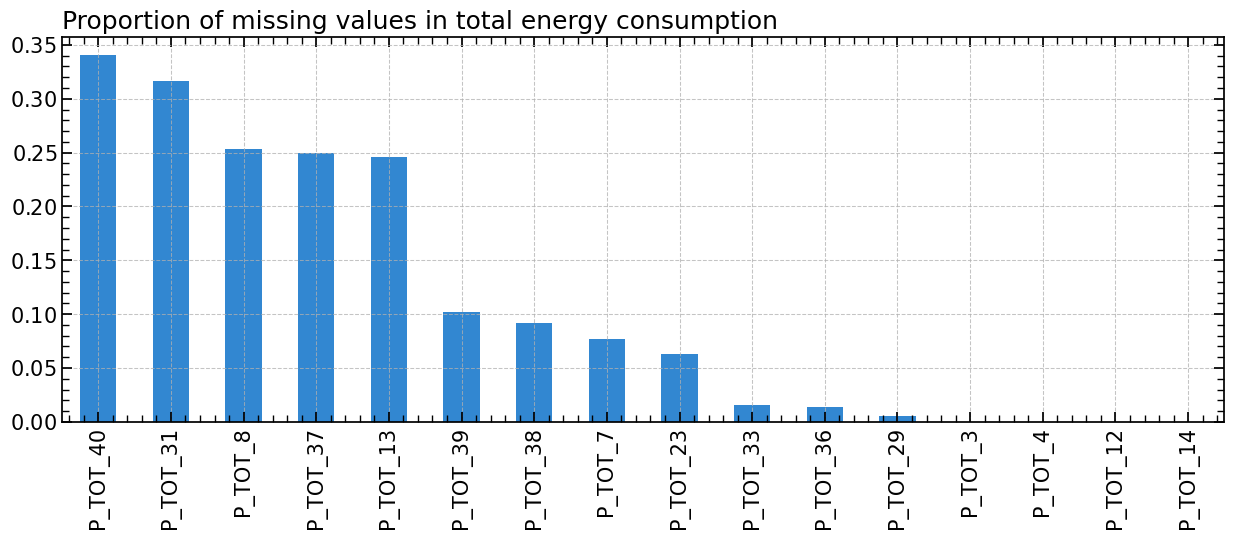

In [20]:

missed_frac = energy.isna().mean(axis=0).sort_values(ascending=False)
missed_frac.plot(kind='bar', figsize=(15, 5), title='Proportion of missing values in total energy consumption')

energy_filled = energy[energy.columns[missed_frac < 0.2]]
cols = list(energy_filled.columns)

orig_cols = [col for col in energy_filled.columns]

energy_filled['P_TOT_AVG'] = energy_filled[orig_cols].mean(axis=1)

[energy_filled] = add_datetime_features([energy_filled])

datetime_cols = energy.columns

#imputing 
#energy_filled_orig = energy_filled.copy()
#energy_filled[orig_cols] = energy_filled[orig_cols].fillna(energy_filled.groupby(by = ['month', 'weekday', 'hour']).transform('median'))

energy_filled = energy_filled[cols + ['P_TOT_AVG'] ]
energy_filled = energy_filled[[energy_filled.columns[-1]] + list(energy_filled.columns[:-1])]


# DARTS time series package

## init darts

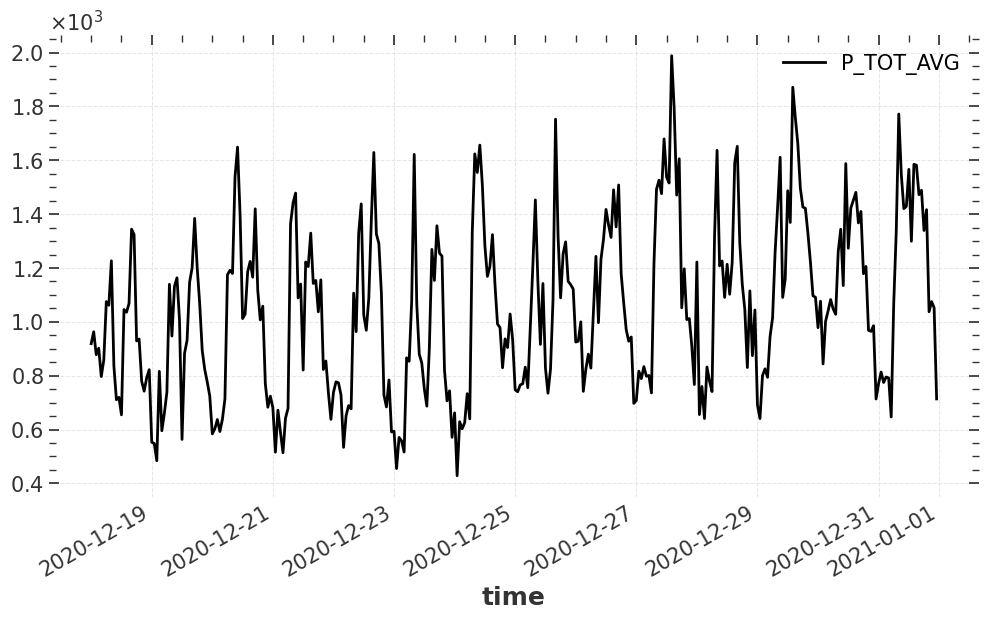

In [21]:
from darts import TimeSeries
from darts.metrics import mape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr



#hierarchy: dict = { col: 'P_TOT_AVG' for col in energy_filled.columns[:-1] }

target_col = ['P_TOT_AVG']
covariates_col = [col for col in energy_filled.columns if col != target_col[0]]

target = TimeSeries.from_dataframe(energy_filled[target_col],freq='H') # multivariate time series

pd_series_list = [energy_filled[x]for x in covariates_col]
energy_covariates = [TimeSeries.from_series(x) for x in pd_series_list] # multivariate time series

weather_covariates = [TimeSeries.from_dataframe(weather[[col]], freq='H') for col in weather.columns]

hodidays_covariates = target.add_holidays("DE", state = "NI")['holidays']


#datetime attributes
#you can try using either one-hot or cyclic encoding instead of default (no encoding)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target.time_index, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target.time_index, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target.time_index, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target.time_index, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

#static covariates: e.g. house number, number of occupants, etc. 

fig,  ax =  plt.subplots( figsize = (12,6))
target.tail(168*2).plot(ax = ax)



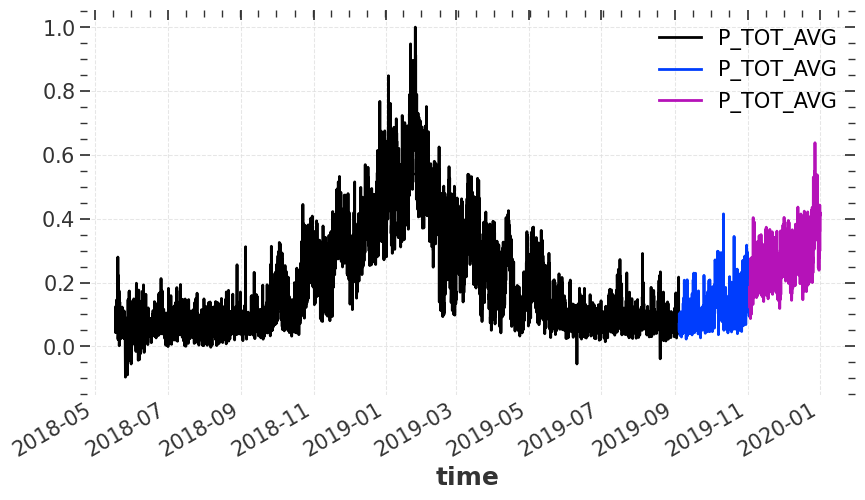

In [22]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase

from sklearn.preprocessing import MaxAbsScaler

target, _ = target.split_before(pd.Timestamp('2020-01-01'))
train, val = target.split_before(0.8)
val, test = val.split_before(0.5)

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

val_len = len(val)


fig,  ax =  plt.subplots( figsize = (10,5))

train.plot(ax = ax)
val.plot(ax = ax)
test.plot(ax = ax)



In [37]:
from darts.models import RandomForest


lags_horizon = 5


model_naive = val.shift(+24) #repeat value from 24 hours ago
model_naive_train = train.shift(+24) 

rf_args = {'lags': lags_horizon, 
        'n_estimators': 500, 'max_depth': 10,
        'max_features': 0.7, 'bootstrap': False}


model_rf = RandomForest(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=lags_horizon,
                    **rf_args)

cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": energy_covariates}

model_rf.fit(train, **cov_args)




models = [model_naive, model_rf]
names = ['naive',  'rf']

KeyboardInterrupt: 

naive mape - train: 38.5671
naive mape - CV: 37.2613
rf mape - train: 27.9966
rf mape - CV: 27.2319


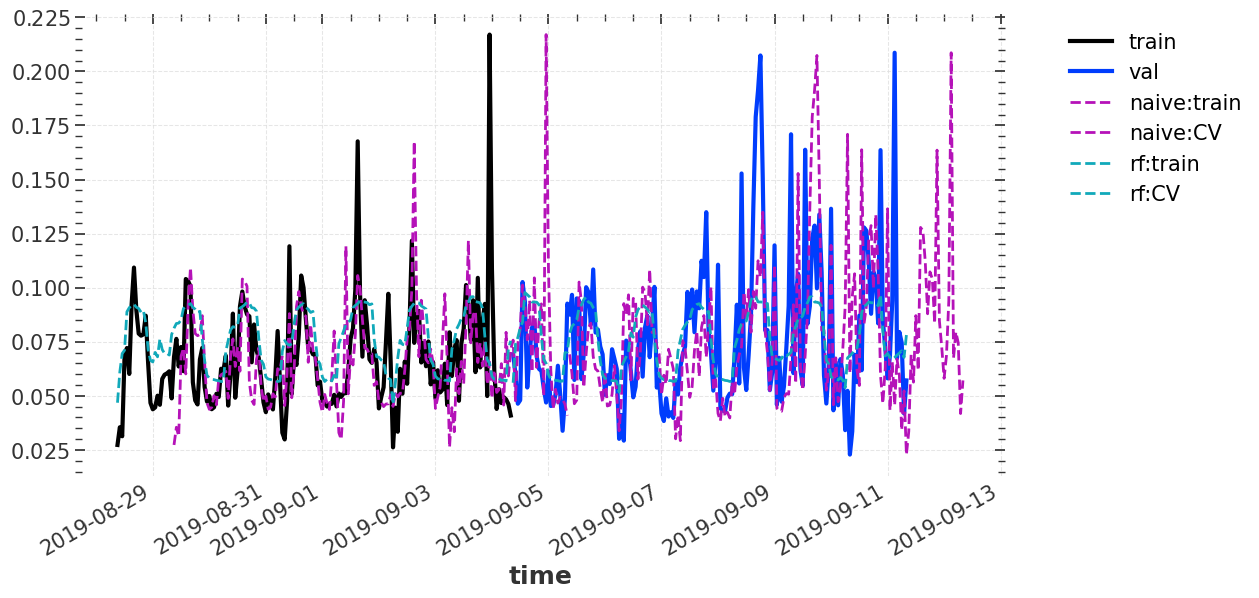

In [24]:
horizon = 24*7*1 #one week ahead


fig,  ax =  plt.subplots( figsize = (12,6))
train.tail(horizon).plot(ax = ax, label = 'train', lw = 3, alpha = 0.2)
val.head(horizon).plot(ax = ax, label = 'val', lw = 3, alpha = 0.2)

for model, name  in zip(models, names):
    if name == 'naive':
        pred_cv = model_naive 
        pred_train = model_naive_train
    else:
        pred_cv = model.predict(horizon, **cov_args)
        pred_train = model.predict(24*7, train[0: -24*7], **cov_args)
    
    
    print(f'{name} mape - train: {mape(train, pred_train):3g}')
    print(f'{name} mape - CV: {mape(val, pred_cv):3g}')
    pred_train.tail(horizon).plot(ax = ax,  ls = '--', lw = 2, label = name+':train')
    color =  ax.get_lines()[-1].get_color()
    pred_cv.head(horizon).plot(ax = ax,  ls = '--', lw = 2, color = color, label = name+':CV')

#put legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )


## interlude: datetime imputing


    Loading Hamelin data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Houses number removed: 6, 17, 24, 25. 
    Houses with PV: ['13', '15', '26', '33'] 
    HOUSEHOLD and HEATPUMP energy consumption are separated. 
    Resolution: 60min 

    May-June 2019 data for home #34 excluded 
    Data before 2018-05-18 excluded (gaps)
    Data with zero difference between consecutive values dropped (malfunction)

    reutrns:
    df_energy: pd.DataFrame with energy consumption data
    df_weather: pd.DataFrame with weather data
    df_metadata: pd.DataFrame with metadata

    


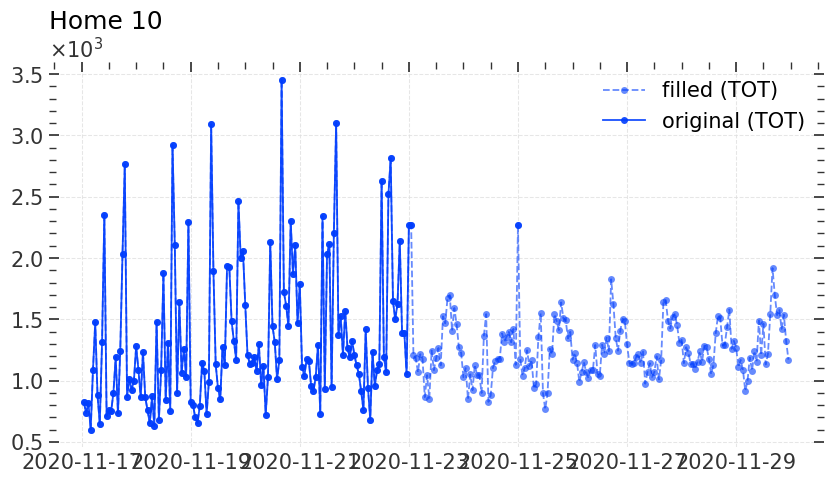

In [36]:

# energy, weather, metadata = read_hamelin()

# energy_filled = energy.copy()

# heat_cols = [col for col in energy.columns if 'P_HEAT' in col]
# home_cols = [col for col in energy.columns if 'P_HOME' in col]
# tot_cols = [col for col in energy.columns if 'P_TOT' in col]

# [energy] = add_datetime_features([energy])
# # interpolate missing values for each home by month, weekday, hour mean 
# for heat_col, home_col, tot_col in zip(heat_cols, home_cols, tot_cols):
#     energy_filled.fillna({heat_col: energy.groupby(by = ['month', 'weekday', 'hour'])[heat_col].transform('median')}, inplace=True)
#     energy_filled.fillna({home_col: energy.groupby(by = ['month', 'weekday', 'hour'])[home_col].transform('median')}, inplace=True)
#     energy_filled.fillna({tot_col: energy.groupby(by = ['month', 'weekday', 'hour'])[tot_col].transform('median')}, inplace=True)


# home_to_plot = 10
# fig,  ax =  plt.subplots( figsize = (10,5))
# query = 'index > "2020-11-17" and index < "2020-11-30"'

# ax.plot(energy_filled.query(query).index, energy_filled.query(query)[f'P_TOT_{home_to_plot}'], 'C1o--', alpha=0.6, label = 'filled (TOT)')
# ax.plot(energy.query(query).index, energy.query(query)[f'P_TOT_{home_to_plot}'], 'C1o-', alpha=0.9, label = 'original (TOT)')

# ax.set_title(f'Home {home_to_plot}')
# ax.legend()